In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

matplotlib.rc("axes", unicode_minus = False)

In [3]:
df1 = pd.read_csv("01 Oxidation.csv")
df2 = pd.read_csv("02 Photo_softbake.csv")
df3 = pd.read_csv("03 Photo_lithograpy.csv")
df4 = pd.read_csv("04 Etching.csv")
df5 = pd.read_csv("05 Ion_Implantation.csv")
df6 = pd.read_csv("06 Inspect.csv")

In [4]:
df = pd.merge(df1, df2, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df3, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df4, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df5, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])
df = pd.merge(df, df6, on=['No_Die','Lot_Num', 'Wafer_Num','Datetime'])

In [5]:
df.dropna(subset="Thin F2", inplace=True) # 다른 변수들과의 연관성을 찾지못함, 한 행에 여러 열들 결측값 가짐
# pd.set_option('display.max_row', 200)
# pd.set_option('display.max_columns', 200)

In [6]:
df['Ox_Chamber'] = df['Ox_Chamber'].astype('str')
df['photo_soft_Chamber'] = df['photo_soft_Chamber'].astype('str')
df['lithography_Chamber'] = df['lithography_Chamber'].astype('str')
df['Etching_Chamber'] = df['Etching_Chamber'].astype('str')
df['Chamber_Num'] = df['Chamber_Num'].astype('str')
df['path'] = df['Ox_Chamber']+df['photo_soft_Chamber']+df['lithography_Chamber']+df['Etching_Chamber']+df['Chamber_Num']

In [7]:
df.drop(df[df['Oxid_time']<0].index, inplace=True) # 산화시간이 음수
df.drop(df[df['Target']==0].index, inplace=True) # target 값이 0
df.drop(columns = ["Wafer_map","Error_message"],inplace=True) # 웨이퍼맵, 에러메시지

In [8]:
# 시간 데이터 datetime 유형으로 변환
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y')

# 195이상 = 불량(1), 195미만 = 양품(0)
df.loc[df['Target'] >= 195, '불량_195이상'] =1
df.loc[df['Target'] < 195, '불량_195이상'] =0

In [9]:
df.loc[df['Thin F4']<0, 'Thin F4']=df['Thin F4'].median()
df.loc[df['Flux90s']<0, 'Flux90s']=df['Flux90s'].median()
df.loc[df['Flux160s']<0, 'Flux160s']=df['Flux160s'].median()
df.loc[df['Flux160s']<5, 'Flux160s']=df['Flux160s'].median()

In [10]:
df['Thin F1'].fillna(df['Thin F1'].median(), inplace=True)
df['Thin F3'].fillna(df['Thin F3'].median(), inplace=True)
df['Flux60s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux90s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux480s'].fillna(df['Flux90s'].median(), inplace=True)
df['Flux840s'].fillna(df['Flux90s'].median(), inplace=True)

### 불필요한 열 제거

In [11]:
# 불필요한 열 제거 
# df.drop(columns=["No_Die", "Lot_Num", "Wafer_Num"], inplace=True)
df.drop(columns=['Vapor','process','Wavelength'])
df.loc[df['Flux840s'] == 8.137500e+16, 'Flux840s'] = df['Flux840s'].mode()[0]
df.loc[df['Flux480s'] == 8.137500e+16, 'Flux480s'] = df['Flux480s'].mode()[0]

In [12]:
df_new = df[['Temp_OXid','ppm','Pressure','type','Oxid_time',
        'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake',
       'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake',
       'temp_softbake', 'time_softbake', 'UV_type', 'Energy_Exposure',       
        'Temp_Etching', 'Source_Power',
       'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp',
       '불량_195이상', 'path']]

In [13]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 데이터 구성:Series, DataFrame
import pandas as pd
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib

# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

df_raw_x = df_new.drop("불량_195이상", axis = 1)
df_raw_y = df_new["불량_195이상"] 

# MinMaxScaler 객체 생성
numeric_columns = df_raw_x.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()

df_raw_x[numeric_columns] = scaler.fit_transform(df_raw_x[numeric_columns])

df_raw_x = pd.get_dummies(df_raw_x, columns=df_raw_x.select_dtypes(include=['object']).columns)
df_raw_x = df_raw_x.astype({column: int for column in df_raw_x.select_dtypes(include=['bool']).columns})

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(
    df_raw_x, df_raw_y, test_size = 0.3, random_state = 1234, stratify=df_raw_y) 

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [16]:
# 로지스틱
logistic_model = LogisticRegression()
logistic_model.fit(df_train_x, df_train_y)

# 의사결정
tree_final = DecisionTreeClassifier(max_depth=13, min_samples_leaf=9, min_samples_split=9,
                       splitter='random')
tree_final.fit(df_train_x, df_train_y)


# 랜덤포레스트
rf_final=RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=12,
                       min_samples_leaf=2, min_samples_split=8, n_estimators=58,
                       random_state=1234)

rf_final.fit(df_train_x, df_train_y)

# 그래디언트 부스팅
best_grad= GradientBoostingClassifier(learning_rate=0.7, max_depth=9, min_samples_leaf=26,
                           n_estimators=216, random_state=1234)

best_grad.fit(df_train_x, df_train_y)

# XGBOOST
xgb_model = xgb.XGBClassifier(learning_rate=0.5,max_depth=6 ,n_estimators= 242,reg_alpha= 5.551695018865267e-08
                              ,reg_lambda= 7.513887184563936e-08, random_state=1234)
xgb_model.fit(df_train_x, df_train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=242, n_jobs=None,
              num_parallel_tree=None, random_state=1234, ...)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = ["로지스틱회귀분석","의사결정나무", "랜덤 포레스트", "그래디언트 부스팅", 'XGBOOST']
accuracy_list, precision_list, recall_list, f1_score_list = [], [], [], []

# 로지스틱 회귀분석 예측
lg_y_pred = logistic_model.predict(df_test_x)

# 평가
accuracy_list.append(accuracy_score(df_test_y, lg_y_pred))
precision_list.append(precision_score(df_test_y, lg_y_pred))
recall_list.append(recall_score(df_test_y, lg_y_pred))
f1_score_list.append(f1_score(df_test_y, lg_y_pred))

# 의사결정나무 예측
dt_y_pred = tree_final.predict(df_test_x)

# 평가
accuracy_list.append(accuracy_score(df_test_y, dt_y_pred))
precision_list.append(precision_score(df_test_y, dt_y_pred))
recall_list.append(recall_score(df_test_y, dt_y_pred))
f1_score_list.append(f1_score(df_test_y, dt_y_pred))

# 랜덤포레스트 예측
rf_y_pred = rf_final.predict(df_test_x)

# 평가
accuracy_list.append(accuracy_score(df_test_y, rf_y_pred))
precision_list.append(precision_score(df_test_y, rf_y_pred))
recall_list.append(recall_score(df_test_y, rf_y_pred))
f1_score_list.append(f1_score(df_test_y, rf_y_pred))

# 그래디언트부스팅 예측
gb_y_pred = best_grad.predict(df_test_x)

# 평가
accuracy_list.append(accuracy_score(df_test_y, gb_y_pred))
precision_list.append(precision_score(df_test_y, gb_y_pred))
recall_list.append(recall_score(df_test_y, gb_y_pred))
f1_score_list.append(f1_score(df_test_y, gb_y_pred))

# XGBoost 예측
xgb_y_pred = xgb_model.predict(df_test_x)

# 평가
accuracy_list.append(accuracy_score(df_test_y, xgb_y_pred))
precision_list.append(precision_score(df_test_y, xgb_y_pred))
recall_list.append(recall_score(df_test_y, xgb_y_pred))
f1_score_list.append(f1_score(df_test_y, xgb_y_pred))

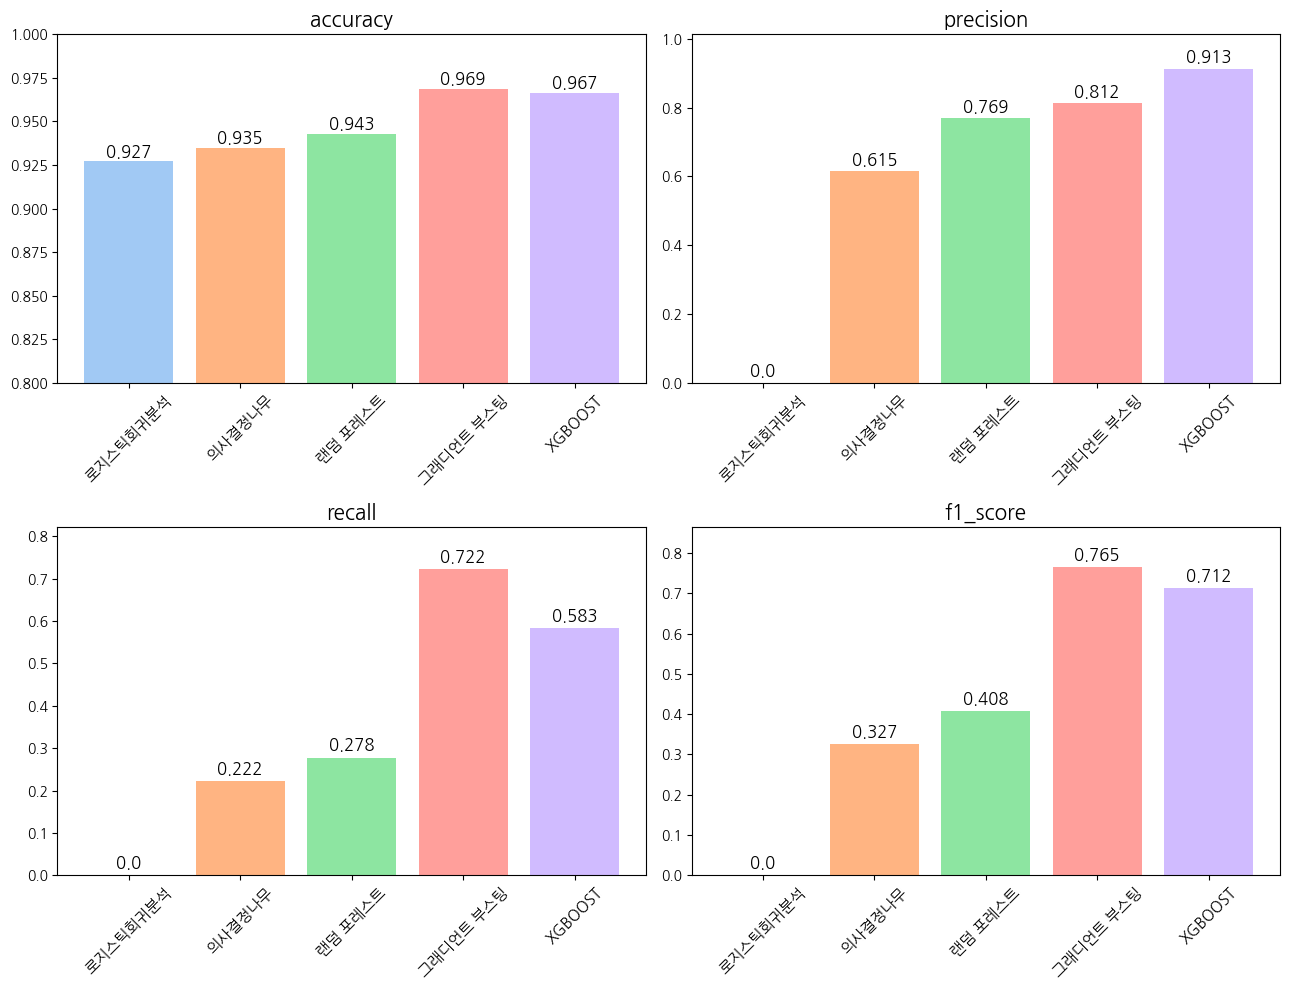

In [18]:
colors = sns.color_palette('pastel')[0:len(models)]

fig, ax = plt.subplots(2, 2, figsize=(13, 10))

ax[0, 0].bar(models, accuracy_list, color=colors)
ax[0, 0].set_title("accuracy", fontsize=15)
for i, v in enumerate(accuracy_list):
    ax[0, 0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[0, 0].set_ylim(0.8, 1.0)  

ax[0, 1].bar(models, precision_list, color=colors)
ax[0, 1].set_title("precision").set_fontsize(15)
for i, v in enumerate(precision_list):
    ax[0, 1].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[0, 1].set_ylim(0, max(precision_list) + 0.1)

ax[1, 0].bar(models,recall_list, color=colors)
ax[1, 0].set_title("recall").set_fontsize(15)
for i, v in enumerate(recall_list):
    ax[1, 0].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[1, 0].set_ylim(0, max(recall_list) + 0.1)

ax[1, 1].bar(models, f1_score_list, color=colors)
ax[1, 1].set_title("f1_score").set_fontsize(15)
for i, v in enumerate(f1_score_list):
    ax[1, 1].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[1, 1].set_ylim(0, max(f1_score_list) + 0.1)

for ax in ax.flat:
    ax.tick_params(axis='x', labelsize=11, rotation=45)  # x축 라벨 회전

plt.tight_layout()  # subplot 간의 간격 조정
plt.show()

In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [20]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_train_x, df_train_y)

In [21]:
# 로지스틱
logistic_model = LogisticRegression()
logistic_model.fit(X_resampled, y_resampled)

# 의사결정
tree_clf1 = DecisionTreeClassifier(max_depth=13, min_samples_leaf=7, min_samples_split=5)
tree_clf1.fit(X_resampled, y_resampled)

# 랜덤포레스트
rf_clf1 = RandomForestClassifier(max_depth=15, min_samples_split=3, n_estimators=400,
                       random_state=1234)
rf_clf1.fit(X_resampled, y_resampled)


# 그래디언트 부스팅
best_grad1= GradientBoostingClassifier(learning_rate=0.5, max_depth=9, min_samples_leaf=8,
                           n_estimators=239, random_state=1234)
best_grad1.fit(X_resampled, y_resampled)

# XGBOOST
xgb_model1 = xgb.XGBClassifier(learning_rate=0.07433674592574852,max_depth=6 ,n_estimators= 181,
                              reg_alpha= 0.08883657957087174,reg_lambda= 0.05472367005012898, 
                              gamma = 0.12620180126392483,
                              random_state=1234)
xgb_model1.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.12620180126392483, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07433674592574852,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=181, n_jobs=None,
              num_parallel_tree=None, random_state=1234, ...)

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = ["로지스틱회귀", "의사결정나무", "랜덤 포레스트", "그래디언트 부스팅", 'XGBOOST']
accuracy_list1, precision_list1, recall_list1, f1_score_list1 = [], [], [], []

# 로지스틱 예측
lg_y_pred = logistic_model.predict(df_test_x)

# 평가 
accuracy_list1.append(accuracy_score(df_test_y, lg_y_pred))
precision_list1.append(precision_score(df_test_y, lg_y_pred))
recall_list1.append(recall_score(df_test_y, lg_y_pred))
f1_score_list1.append(f1_score(df_test_y, lg_y_pred))

# 의사결정나무 예측
dt_y_pred = tree_clf1.predict(df_test_x)

# 평가
accuracy_list1.append(accuracy_score(df_test_y, dt_y_pred))
precision_list1.append(precision_score(df_test_y, dt_y_pred))
recall_list1.append(recall_score(df_test_y, dt_y_pred))
f1_score_list1.append(f1_score(df_test_y, dt_y_pred))

# 랜덤포레스트 예측
rf_y_pred = rf_clf1.predict(df_test_x)

# 평가
accuracy_list1.append(accuracy_score(df_test_y, rf_y_pred))
precision_list1.append(precision_score(df_test_y, rf_y_pred))
recall_list1.append(recall_score(df_test_y, rf_y_pred))
f1_score_list1.append(f1_score(df_test_y, rf_y_pred))

# 그래디언트부스팅 예측
gb_y_pred = best_grad1.predict(df_test_x)

# 평가
accuracy_list1.append(accuracy_score(df_test_y, gb_y_pred))
precision_list1.append(precision_score(df_test_y, gb_y_pred))
recall_list1.append(recall_score(df_test_y, gb_y_pred))
f1_score_list1.append(f1_score(df_test_y, gb_y_pred))

# XGBoost 예측
xgb_y_pred = xgb_model1.predict(df_test_x)

# 평가
accuracy_list1.append(accuracy_score(df_test_y, xgb_y_pred))
precision_list1.append(precision_score(df_test_y, xgb_y_pred))
recall_list1.append(recall_score(df_test_y, xgb_y_pred))
f1_score_list1.append(f1_score(df_test_y, xgb_y_pred))

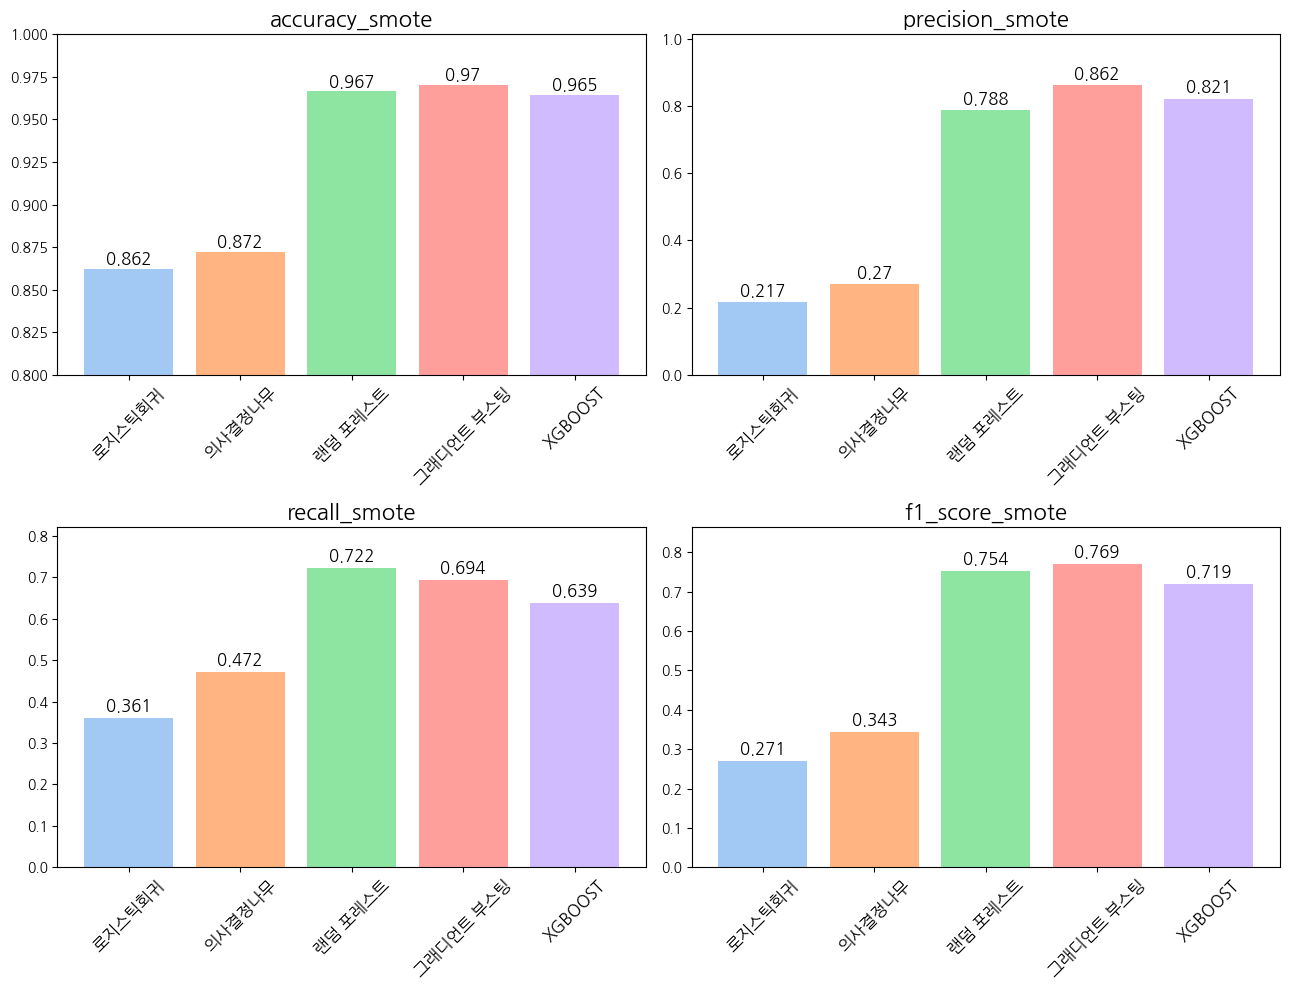

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('pastel')[0:len(models)]

fig, ax = plt.subplots(2, 2, figsize=(13, 10))

ax[0, 0].bar(models, accuracy_list1, color=colors)
ax[0, 0].set_title("accuracy_smote").set_fontsize(16)
for i, v in enumerate(accuracy_list1):
    ax[0, 0].text(i, v + 0.001, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[0, 0].set_ylim(0.8, 1)

ax[0, 1].bar(models, precision_list1, color=colors)
ax[0, 1].set_title("precision_smote").set_fontsize(16)
for i, v in enumerate(precision_list1):
    ax[0, 1].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[0, 1].set_ylim(0, max(precision_list) + 0.1)

ax[1, 0].bar(models, recall_list1, color=colors)
ax[1, 0].set_title("recall_smote").set_fontsize(16)
for i, v in enumerate(recall_list1):
    ax[1, 0].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[1, 0].set_ylim(0, max(recall_list) + 0.1) 

ax[1, 1].bar(models, f1_score_list1, color=colors)
ax[1, 1].set_title("f1_score_smote").set_fontsize(16)
for i, v in enumerate(f1_score_list1):
    ax[1, 1].text(i, v + 0.01, str(round(v, 3)), ha='center', va='bottom', fontsize=12)
ax[1, 1].set_ylim(0, max(f1_score_list) + 0.1)

for ax in ax.flat:
    ax.tick_params(axis='x', labelsize=12, rotation=45)

plt.tight_layout()
plt.show()